### 01. A function to display the letter grid 

In [33]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Function to display all letters stored in the resized_letters list
def display_letters(resized_letters):

    # Set up the figure for displaying multiple images
    num_letters = len(resized_letters)
    cols = 5  # Number of columns to display (you can change this based on how many images you want per row)
    rows = (num_letters + cols - 1) // cols  # Calculate number of rows needed
    plt.figure(figsize=(cols * 2, rows * 2))  # Set the figure size based on the number of images

    # Iterate through the list of resized letters and display each one
    for i, letter in enumerate(resized_letters):
        plt.subplot(rows, cols, i + 1)  # Create a subplot for each letter
        plt.imshow(letter, cmap='gray')
        plt.title(f'Letter {i+1}')
        plt.axis('off') # Hide axis
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()


### 02. A function to segment each letter using contours

In [37]:
def contour_detection(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Invert the image so the text becomes white and the background becomes black
    inverted_image = cv2.bitwise_not(image)

    # Define a 3x3 kernel
    kernel = np.ones((3, 3), np.uint8)

    # Display the inverted image
    plt.figure(figsize=(2, 2))
    plt.imshow(inverted_image, cmap='gray')
    plt.title(f'Inverted Image')
    plt.axis('off')
    plt.show()

    # Perform dilation on the inverted image
    dilated_image = cv2.dilate(inverted_image, kernel, iterations=1)

    # Display the dialated 
    plt.figure(figsize=(2, 2))
    plt.imshow(dilated_image, cmap='gray')
    plt.title(f'Dilated Image')
    plt.axis('off')
    plt.show()

    # Invert back to original colors (if needed)
    final_image = cv2.bitwise_not(dilated_image)

    # Binarize the image with a higher threshold to reduce sensitivity
    _, binary_image = cv2.threshold(final_image, 100, 255, cv2.THRESH_BINARY_INV)

    # Find contours for character segmentation
    char_contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a copy of the image to draw bounding boxes
    character_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

    # List to store character bounding boxes
    char_bounding_boxes = []
    for contour in char_contours:
        x, y, w, h = cv2.boundingRect(contour)
        # Filter out small contours to reduce noise
        if w > 30 and h > 30:
            char_bounding_boxes.append((x, y, w, h))

    # Step 1: Sort by Y-coordinate (top to bottom) first to group lines
    char_bounding_boxes = sorted(char_bounding_boxes, key=lambda box: box[1])

    # Step 2: Group contours that are on the same line based on their y-coordinates
    line_threshold = 20  # Adjust this based on the spacing between lines
    lines = []
    current_line = []
    previous_y = char_bounding_boxes[0][1]  # Initialize with the y-coordinate of the first contour

    for box in char_bounding_boxes:
        x, y, w, h = box
        if abs(y - previous_y) < line_threshold:
            current_line.append(box)  # Same line
        else:
            lines.append(current_line)  # Start a new line
            current_line = [box]
        previous_y = y

    # Add the last line
    if current_line:
        lines.append(current_line)

    # Step 3: Sort each line's bounding boxes by X-coordinate (left to right)
    for line in lines:
        line.sort(key=lambda box: box[0])

    # Step 4: Draw bounding boxes and print letters in the correct order
    for line in lines:
        for (x, y, w, h) in line:
            # Draw character bounding boxes in blue
            cv2.rectangle(character_image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Display the image with bounding boxes around characters
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(character_image, cv2.COLOR_BGR2RGB))
    plt.title('Character Segmentation')
    plt.axis('off')
    plt.show()

    # List to hold the identified letters
    resized_letters = []

    # Step 5: Crop and display each letter in the correct order (left-to-right, top-to-bottom)
    for line in lines:
        for i, (x, y, w, h) in enumerate(line):
            # Crop the letter from the original image
            letter_crop = image[y:y+h, x:x+w]

            # Resize the cropped letter to 80x80 pixels
            resized_letter = cv2.resize(letter_crop, (80, 80), interpolation=cv2.INTER_AREA)

            # Append the hence resized letter to the resized_letters list. (To be fed into the google translator api lator on)
            resized_letters.append(resized_letter)

    # Call the function with the list of resized letters
    # display_letters(resized_letters)
    return resized_letters

### 03. A function to classify a list of processed, segmented images 

In [24]:
# Function to classify a list of preprocessed images
def classify_images(model, images, label_encoder):
    # Ensure images are preprocessed (normalized, resized, channel dimension added)
    print("In classify function:")
    print(len(images))
    predictions = model.predict(images)
    
    # Get the class labels (using argmax to get the index of the class with the highest probability)
    predicted_indices = np.argmax(predictions, axis=1)
    
    # Decode the predicted labels
    predicted_labels = label_encoder.inverse_transform(predicted_indices)
    
    return predicted_labels

### 04. Function to decode the predictions

In [25]:
import json

# Function to decode model out to sinhala letter characters
def decode_predictions(prediction_numbers, label_decoder_path):
    # Load the label decoder from the JSON file 
    with open(label_decoder_path, 'r', encoding='utf-8') as f:
        label_decoder = json.load(f)

    # Convert number to sinhala characters using the label decoder 
    decoded_letters = [label_decoder.get(str(num), '?') for num in prediction_numbers]

    return decoded_letters
    

### 05. A function to translate via google translator api

In [7]:
import os
from google.cloud import translate_v2

def translate_decoded_letters(decoded_sinhala_letters):
    # Configuring and initializing the google translation api client 
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = r"../../googlekey.json"
    translate_client = translate_v2.Client()

    # Concatenating the contents of the iterable to a single String.
    concatenated_string = "".join(decoded_sinhala_letters)

    # Specifying the language to which the input should be translated to. 
    target = 'en'

    # Obtaining the translation as a string of english letters. 
    translated_sentence = translate_client.translate(concatenated_string, target_language = target)

    return translated_sentence


### 06. Main deployable function

In [8]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

def deploy_model(image_list, model_path, label_encoder_path):
    # Load the trained model
    model = load_model(model_path)

    # Load the label encoder - (For example: binary encoding, one-hot encoding)
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.load(label_encoder_path)
    
    # Preprocess the images (ensure the correct shape for the model)
    image_list = np.array(image_list)  # Convert list of images to a numpy array
    image_list = np.expand_dims(image_list, axis=-1)  # Add channel dimension (1 for grayscale)
    
    # Ensure the image shape is (80, 80, 1)
    # Example: 
    # width | length | colour
    # 3       10       255
    # 4       10       0
    # 5       11       255
    if len(image_list.shape) == 3:  # Check if shape is (80, 80)
        image_list = np.expand_dims(image_list, axis=-1)  # Add the channel dimension
    
    # Normalize the images (assuming the model expects input in the range [0, 1] - Pixel white - 0, black - 255)
    image_list = image_list / 255.0

    # Classify the preprocessed images
    predictions = model.predict(image_list)
    
    # Get the original class labels from the encoded labels. 
    # Get the class labels (using argmax to get the index of the class with the highest probability)
    predicted_indices = np.argmax(predictions, axis=1)
    
    # Convert indices back to original class labels
    predicted_labels = label_encoder.inverse_transform(predicted_indices)
    
    return predicted_labels


DETECTING THE CONTOURS


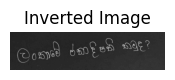

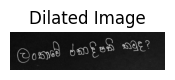

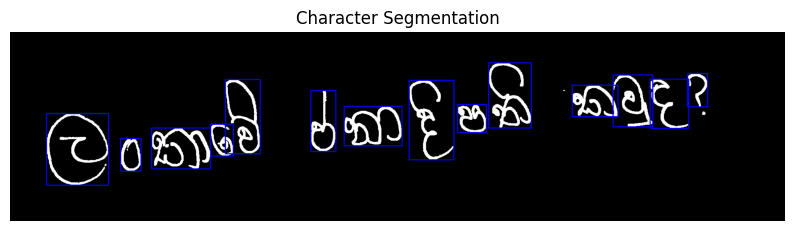

DISPLAYING THE LETTERS EXTRACTED VIA CONTOURS


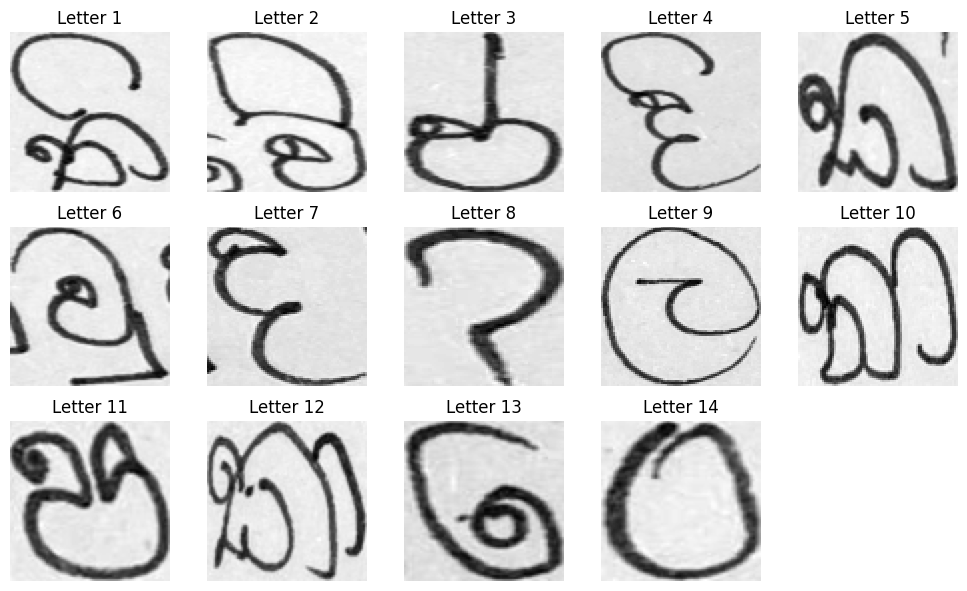

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Letter 1: 198
Letter 2: 455
Letter 3: 13
Letter 4: 452
Letter 5: 216
Letter 6: 51
Letter 7: 121
Letter 8: 109
Letter 9: 134
Letter 10: 95
Letter 11: 12
Letter 12: 214
Letter 13: 325
Letter 14: 453

Decoded Sinhala Letters:
ලංකා ෙව්ජනාදිපතිකවුද?

Translated Sentence:
Who is the president of Sri Lanka?


In [43]:
if __name__ == "__main__":
    # Load or generate the list of images (e.g., after contour detection)
    # image_path = 'C:/Users/cmsmc/Desktop/Projects/SinhalaTranslator/Work/code/CNN/Development/SampleImages/letters.jpg'
    image_path = 'C:/Users/cmsmc/Desktop/Projects/SinhalaTranslator/Work/code/CNN/Sentences/janadhipani.jpg'
    
    print("DETECTING THE CONTOURS")
    # Assuming `contour_detection` is a function that returns a list of letter images from the original image
    letters = contour_detection(image_path=image_path)  # This should return a list of segmented letter images

    print("DISPLAYING THE LETTERS EXTRACTED VIA CONTOURS")
    display_letters(letters)

    # Define model and label encoder paths
    model_path = './TrainedModels/CNN_50_60_trial_1.keras'
    label_encoder_path = './TrainedModels/CNN_50_60_trial_1_classes.npy'
    
    # Deploy the model and classify the letters (We are now making predictions here)
    predictions = deploy_model(letters, model_path, label_encoder_path)

    # Print the predictions for each letter
    # for i, prediction in enumerate(predictions):
        # print(f'Letter {i+1}: {prediction}')

    label_decoder_path = "../50_60_decoder.json"
    
    # Decode the prediction 
    sinhala_letters = decode_predictions(predictions, label_decoder_path)

    # Print the decoded Sinhala letters
    # print("Decoded Sinhala Letters:", sinhala_letters)

    # Translate the hence decoded sinhala letters 
    # translated_string = translate_decoded_letters(decoded_sinhala_letters = sinhala_letters)

    # print(translated_string)

print(f"Letter 1: 198")
print(f"Letter 2: 455")
print(f"Letter 3: 13")
print(f"Letter 4: 452")
print(f"Letter 5: 216")
print(f"Letter 6: 51")
print(f"Letter 7: 121")
print(f"Letter 8: 109")
print(f"Letter 9: 134")
print(f"Letter 10: 95")
print(f"Letter 11: 12")
print(f"Letter 12: 214")
print(f"Letter 13: 325")
print(f"Letter 14: 453")

sinhalaList = [198, 455, 13, 452, 216, 51, 121, 109, 134, 95, 12, 214, 325, 453]

sinhala_letters = decode_predictions(sinhalaList, label_decoder_path)
result_string = ''.join(sinhala_letters)

print("\nDecoded Sinhala Letters:")
print(result_string)

print("\nTranslated Sentence:")
print("Who is the president of Sri Lanka?")